## Murine bone-marrow derived macrophages

https://data.broadinstitute.org/bbbc/BBBC020/

## Make a torch dataset

In [1]:
from segmentation.datasets import BroadDataset

### Show some images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#base = '/Users/nicholassofroniew/Documents/BBBC/BBBC020_v1/BBBC020_v1-cells'
base = '/Users/nicholassofroniew/Documents/DATA/neurofinder/mean'
train_dataset = BroadDataset(base, 'train')

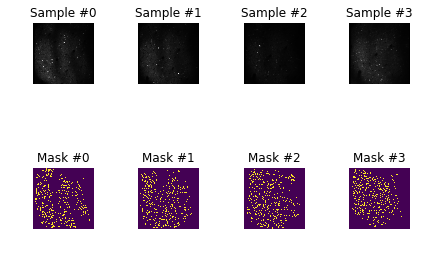

In [4]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [5]:
from numpy import asarray
tmp = asarray(img)
tmp.max()

255

## Define transforms

In [6]:
from torchvision import transforms
import segmentation.transforms as extended_transforms

joint_transform = extended_transforms.Compose([
    extended_transforms.RandomHorizontallyFlip(),
    extended_transforms.RandomVerticallyFlip(),
#    extended_transforms.CenterCrop(512),
#    extended_transforms.RandomRotate(45),
    extended_transforms.RandomWarp(5, 20)])

input_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     ])
target_transform = extended_transforms.MaskToTensor()

In [7]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform)

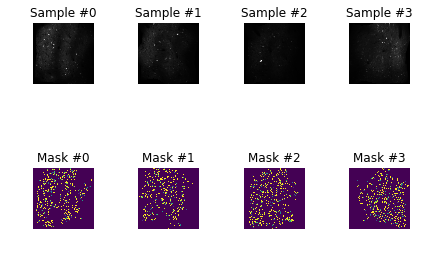

In [8]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [9]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform, input_transform=input_transform, target_transform=target_transform)

In [10]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

## Load network

In [11]:
from segmentation.model import UNet

In [12]:
net = UNet(1)

In [13]:
net.train()

UNet (
  (enc1): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc2): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc3): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
     

### Define loss function and optimizer

In [14]:
from segmentation.utilities import mIoULoss, CrossEntropyLoss2d, BCELoss2d

In [15]:
from torch import nn
criterion = mIoULoss(size_average=False)
#criterion = nn.NLLLoss2d()
#criterion = nn.BCEWithLogitsLoss()

In [16]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Pass data throuhg network

In [17]:
import torch.nn.functional as F
from torch.autograd import Variable
img, mask = train_dataset[0]
tmp = Variable(mask).unsqueeze(0)
foo = net(Variable(img).unsqueeze(0)).squeeze(0)

In [18]:
print(tmp)
print(foo)
#print(bar)

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.LongTensor of size 1x512x512]

Variable containing:
( 0 ,.,.) = 
 -1.7297e+00 -1.7280e+00 -1.7069e+00  ...  -1.7028e+00 -1.6898e+00 -1.6704e+00
 -1.4926e+00 -1.5962e+00 -1.6318e+00  ...  -1.5914e+00 -1.5838e+00 -1.6007e+00
 -1.4484e+00 -1.5842e+00 -1.6425e+00  ...  -1.5804e+00 -1.5765e+00 -1.6103e+00
                 ...                   ⋱                   ...                
 -1.5953e+00 -1.6736e+00 -1.7148e+00  ...  -7.2789e-01 -7.7675e-01 -8.0372e-01
 -1.6371e+00 -1.7058e+00 -1.7145e+00  ...  -6.7767e-01 -7.0509e-01 -7.0542e-01
 -1.5591e+00 -1.6556e+00 -1.6271e+00  ...  -5.0955e-01 -5.3616e-01 -6.2957e-01
[torch.FloatTensor of size 1x512x512]



In [19]:
loss = criterion(foo, tmp)
print(loss)

Variable containing:
 93.2161
[torch.FloatTensor of size 1]



In [20]:
loss.backward()

### Train network

In [21]:
from segmentation.main import train

In [ ]:
for epoch in range(200):  # loop over the dataset multiple times
    train(trainloader, net, criterion, optimizer, epoch, 19)
print('Finished Training')

### Load and save model

In [22]:
import torch
from os.path import join
snapshot_name = 'UNet_0'

In [24]:
torch.save(net.state_dict(), join(base, 'models', snapshot_name + '.pth'))
torch.save(optimizer.state_dict(), join(base, 'models', 'opt_' + snapshot_name + '.pth'))

In [34]:
net.load_state_dict(torch.load(join(base, 'models', snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))
optimizer.load_state_dict(torch.load(join(base, 'models', 'opt_' + snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))

### Look at perforance on validation set

In [24]:
from torchvision import transforms
import segmentation.transforms as extended_transforms

input_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     ])
target_transform = extended_transforms.MaskToTensor()

In [25]:
val_dataset = BroadDataset(base, 'train', input_transform=input_transform, target_transform=target_transform)

In [26]:
from torch.autograd import Variable
img, mask = val_dataset[0]
output = net(Variable(img).unsqueeze(0))

In [27]:
prediction = F.sigmoid(output)

74.8731


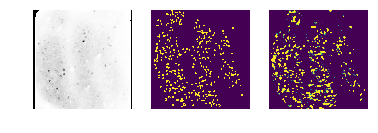

In [28]:
ax = plt.subplot(1,3,1);
plt.imshow(255*img.numpy().transpose(1,2,0))
ax.axis('off');
ax = plt.subplot(1,3,2);
plt.imshow(mask.numpy())
ax.axis('off');
ax = plt.subplot(1,3,3);
plt.imshow(prediction.squeeze(0).squeeze(0).data.numpy())
ax.axis('off');
loss = criterion(output, Variable(mask).unsqueeze(0))
print(loss.data.numpy()[0])

In [29]:
valloader = DataLoader(val_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

In [50]:
correct = 0
total = 0
for data in valloader:
    images, labels = data
    outputs = net(Variable(images))
    loss = criterion(output, Variable(labels)).data.numpy()[0]

    print(loss)
    total += labels.size(0)
    correct += loss

print('Mean Loss: %.2f %%' % (
    correct / total))

81.0965
97.4433
Mean Loss: 89.27 %


In [30]:
predict = prediction.squeeze(0).squeeze(0).data.numpy()

In [31]:
from skimage.io import imsave

In [32]:
imsave(join(base, 'predict_0000.tif'), (255*predict).astype('uint8'), plugin='tifffile', photometric='minisblack')

In [33]:
predict.shape

(512, 512)